没有障碍物，dqn

In [26]:
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import os
import envlx_only
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
env = envlx_only.DroneEnv()

C:\ProgramData\anaconda3\envs\UAV\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [27]:
import gym
print('gym版本：',gym.__version__)

gym版本： 0.26.2


In [28]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [29]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [30]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子 折扣因子，影响长期奖励对当前奖励的权重。
        self.epsilon = epsilon  # epsilon-贪婪策略，用于在探索和利用之间做出权衡
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作根据给定的状态选择动作。它使用了 ε 的概率随机选择动作，以探索环境，而以 1-ε 的概率选择具有最高 Q 值的动作，以利用已知信息。
        if np.random.random() < self.epsilon:
            #print("------------------------")
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
            #print(action)
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1
    def save_model(self, save_path):
        torch.save({
            'q_net_state_dict': self.q_net.state_dict(),
            'target_q_net_state_dict': self.target_q_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'count': self.count
        }, save_path)


In [42]:
lr = 1e-3
num_episodes = 20000
hidden_dim = 128
gamma = 0.99
epsilon = 0.25
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(state_dim )
print(action_dim)
print(env.observation_space)
#print(env.action_space)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)


1
3
Box(-3.1415927, 3.1415927, (1,), float32)


Iteration 0:   1%|          | 12/2000 [00:00<00:22, 88.25it/s, episode=10, return=62.264]

历史最优reward，已保存模型！


Iteration 0:   4%|▍         | 86/2000 [00:03<01:45, 18.19it/s, episode=80, return=-238.323]

历史最优reward，已保存模型！
历史最优reward，已保存模型！


Iteration 0:   4%|▍         | 90/2000 [00:03<01:57, 16.21it/s, episode=90, return=703.672] 

历史最优reward，已保存模型！


Iteration 0:   5%|▌         | 106/2000 [00:05<02:35, 12.17it/s, episode=100, return=420.023]

历史最优reward，已保存模型！


Iteration 0:  28%|██▊       | 558/2000 [00:30<01:54, 12.62it/s, episode=550, return=-59.329] 

历史最优reward，已保存模型！


Iteration 0:  30%|███       | 603/2000 [00:33<02:00, 11.63it/s, episode=600, return=457.288] 

历史最优reward，已保存模型！


Iteration 0: 100%|██████████| 2000/2000 [02:03<00:00, 16.21it/s, episode=2000, return=451.650] 


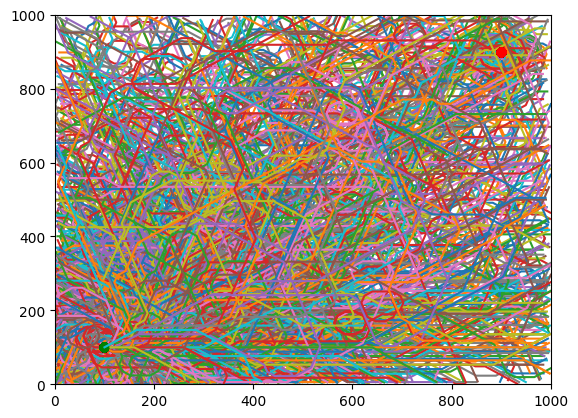

Iteration 1:  90%|█████████ | 1809/2000 [01:59<00:13, 13.66it/s, episode=3800, return=408.144] 

历史最优reward，已保存模型！


Iteration 1: 100%|██████████| 2000/2000 [02:12<00:00, 15.10it/s, episode=4000, return=229.856] 


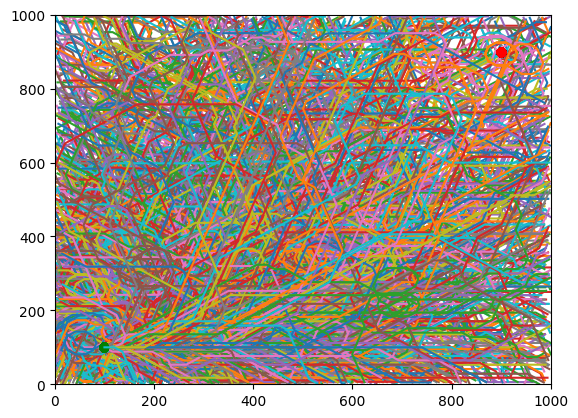

Iteration 2:  18%|█▊        | 359/2000 [00:21<01:29, 18.24it/s, episode=4360, return=149.098] 

历史最优reward，已保存模型！


Iteration 2: 100%|██████████| 2000/2000 [02:05<00:00, 15.97it/s, episode=6000, return=313.104] 


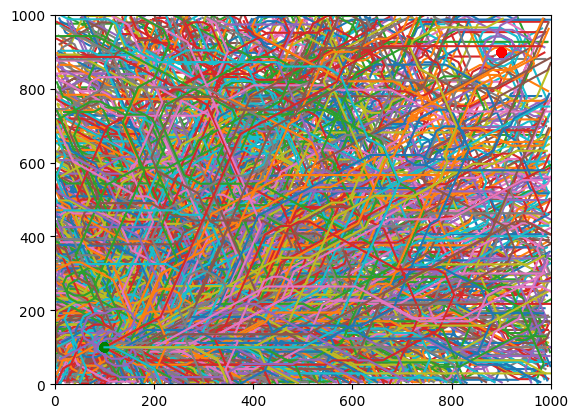

Iteration 3: 100%|██████████| 2000/2000 [02:11<00:00, 15.24it/s, episode=8000, return=63.133]  


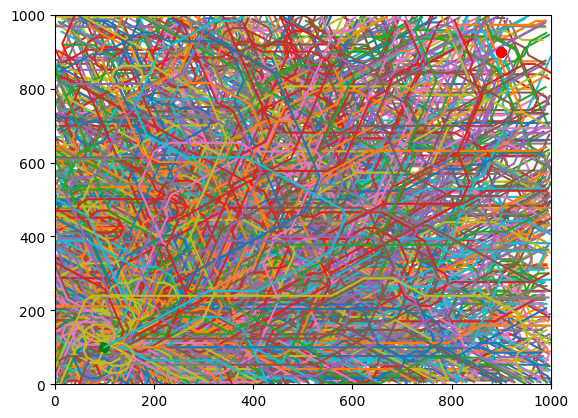

Iteration 4: 100%|██████████| 2000/2000 [02:05<00:00, 15.93it/s, episode=10000, return=131.145]


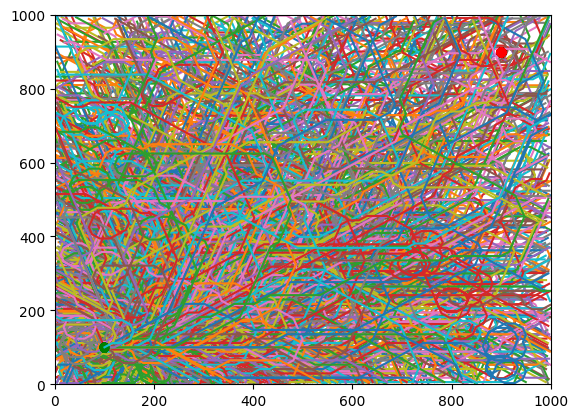

Iteration 5: 100%|██████████| 2000/2000 [02:11<00:00, 15.16it/s, episode=12000, return=203.966] 


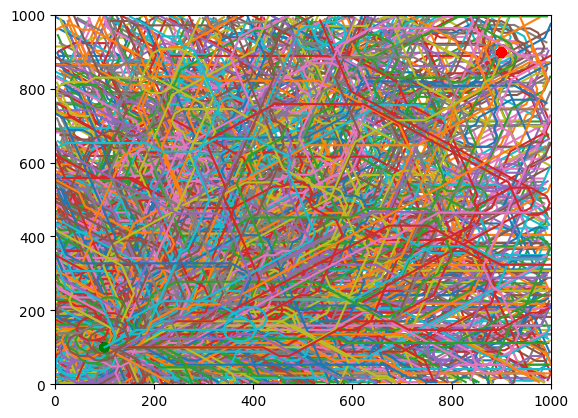

Iteration 6:  20%|██        | 403/2000 [00:27<02:33, 10.41it/s, episode=12400, return=94.473]  

历史最优reward，已保存模型！


Iteration 6: 100%|██████████| 2000/2000 [02:16<00:00, 14.68it/s, episode=14000, return=173.172] 


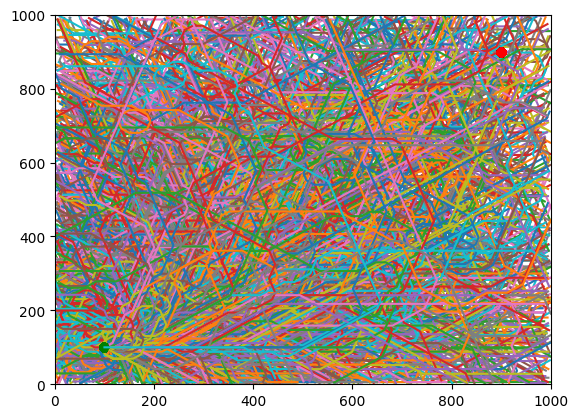

Iteration 7: 100%|██████████| 2000/2000 [01:35<00:00, 20.84it/s, episode=16000, return=191.640] 


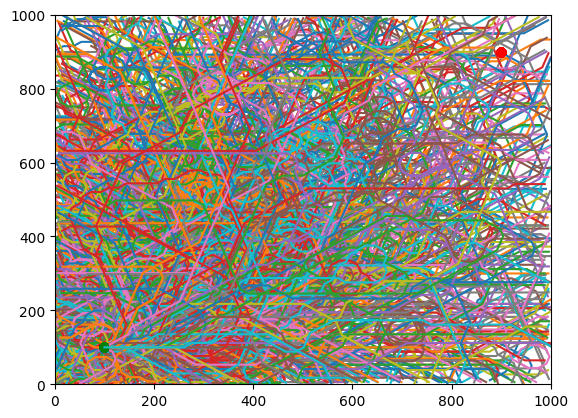

Iteration 8:  17%|█▋        | 333/2000 [00:19<01:34, 17.60it/s, episode=16330, return=492.072]

历史最优reward，已保存模型！


Iteration 8: 100%|██████████| 2000/2000 [01:44<00:00, 19.13it/s, episode=18000, return=214.674] 


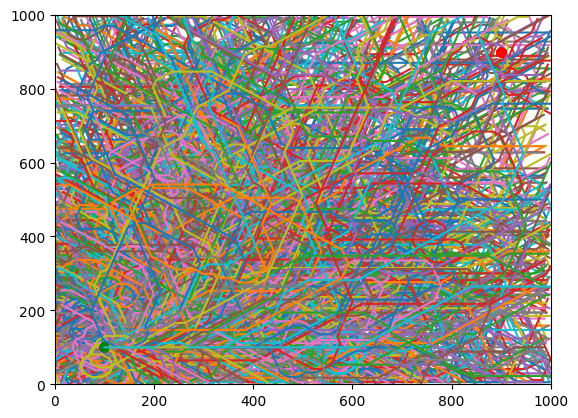

Iteration 9: 100%|██████████| 2000/2000 [01:51<00:00, 17.92it/s, episode=20000, return=-202.613]


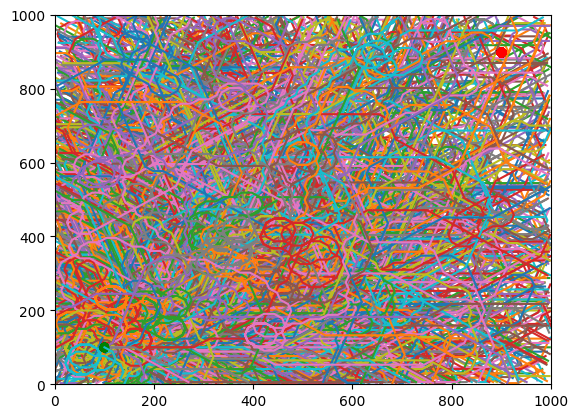

In [43]:
#训练模型
return_list = []
maxReward = -np.inf
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            #绘制x,y轴
            X=[]
            Y=[]
            count = 0
            while not done:
                X.append(env.xy[0])
                Y.append(env.xy[1])
                count+=1
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                #print(state,action,reward)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                if (count>100):
                    done = True
            #保存最优模型
            if episode_return > maxReward:
                maxReward = episode_return
                print("历史最优reward，已保存模型！")
                # 保存模型状态字典
                agent.save_model('TrainedModel/Actor.pth')


            #画图可视化
            plt.plot(100, 100, 'go')  # 'ro'表示红色的点
            plt.plot(900, 900, 'ro')  # 'ro'表示红色的点
            plt.xlim(0, 1000)
            plt.ylim(0, 1000)
            plt.plot(X,Y)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
    plt.show()

[-0.7853981633974483]
[-1.4312233512813972] 0 -0.08845265436684713
[-2.075060381425594] 0 -25.054785369842193
[-2.7107196682845127] 0 -42.28273956103976
[2.947484102531968] 0 -45.2359269117178
[2.331488043875596] 0 -33.39838626486517
[1.7197991475433074] 0 -11.609168044737544
[1.1064807445136093] 0 12.180683758519535
[0.48605916165238927] 0 29.441007313575483
[1.1298987042890376] 2 11.350796818575418
[1.145650429213446] 1 10.785143438034538
[1.161630059979144] 1 10.206999610098592
[1.1778342422868855] 1 9.616444251773373
[0.5588805672280124] 0 28.013280954591664
[-0.0707046889675853] 0 33.90184836153048
[-0.710937139239114] 0 24.465516378114444
[-1.3573511690836142] 0 2.826831859928461
[-2.002555083464321] 0 -22.432028334812912
[-2.0191817810990553] 1 -23.040776916434424
[-2.6560436397259437] 0 -41.29701155716248
[-2.664319013630557] 1 -41.45399622343257
[2.9931699019605755] 0 -45.55246680028904
[2.376915864309181] 0 -34.69719829035921
[1.7654839809341638] 0 -13.407043554618213
[2.4053

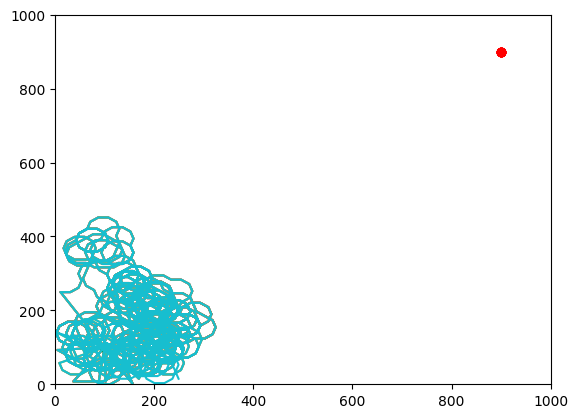

In [44]:
state = env.reset()
print(state)
done = False
 #绘制x,y轴 
X=[]
Y=[]


for i in range(10):
    state = env.reset()
    done = False
    while not done:
        X.append(env.xy[0])
        Y.append(env.xy[1])
        action = agent.take_action(state)
        #print(action)
        next_state, reward, done = env.step(action)
        state = next_state
        print(state,action,reward)
    #画图可视化
    plt.plot(100, 100, 'go')  # 'ro'表示红色的点
    plt.plot(900, 900, 'ro')  # 'ro'表示红色的点
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)
    plt.plot(X,Y)
plt.show()

[-0.7853981633974483]


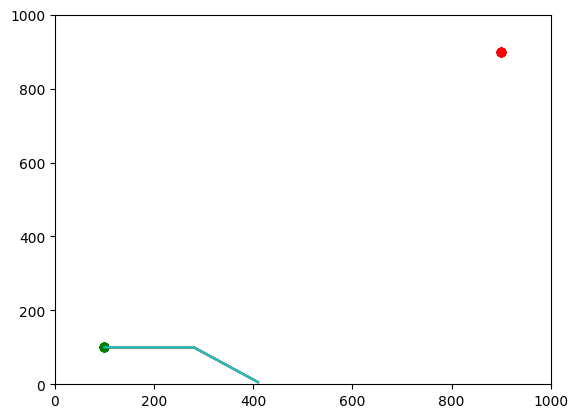

In [45]:
state = env.reset()
print(state)
done = False
 #绘制x,y轴
X=[]
Y=[]
# 加载模型状态字典
checkpoint = torch.load('TrainedModel/Actor.pth')

# 创建一个新的 DQN 实例
new_agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
# 将加载的状态字典加载到新的 DQN 实例中
new_agent.q_net.load_state_dict(checkpoint['q_net_state_dict'])
new_agent.target_q_net.load_state_dict(checkpoint['target_q_net_state_dict'])
new_agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 现在，new_dqn_instance 就包含了之前保存的模型的状态
for i in range(10):
    while not done:
        X.append(env.xy[0])
        Y.append(env.xy[1])
        action = new_agent.take_action(state)
        #print(action)
        next_state, reward, done = env.step(action)
        state = next_state
        #print(reward)
    
    #画图可视化
    plt.plot(100, 100, 'go')  # 'ro'表示红色的点
    plt.plot(900, 900, 'ro')  # 'ro'表示红色的点
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)
    plt.plot(X,Y)
plt.show()

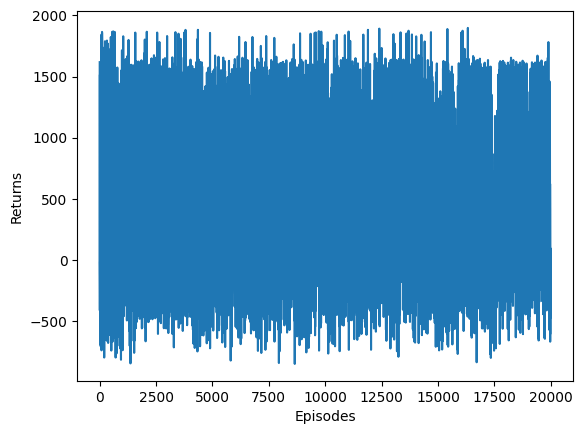

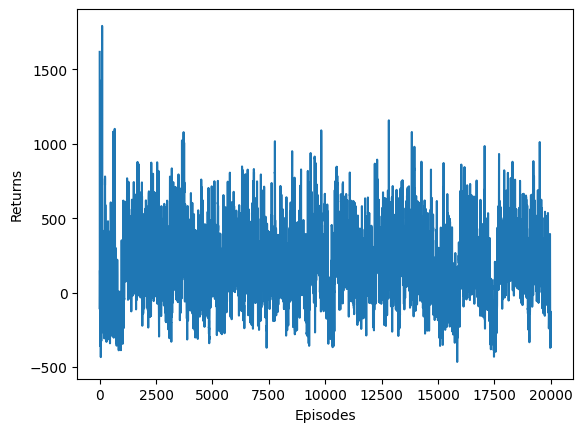

In [46]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('DQN on {}'.format(env_name))
plt.show()

In [31]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)